In [1]:

import pandas as pd

# Load the cleaned evaluation data
df = pd.read_pickle('merged_eval_data.pkl')


In [2]:
df
# Keep only narrative_id and columns with '_cleaned' in the name
cleaned_cols = [col for col in df.columns if '_cleaned' in col]
cleaned_cols.append('narrative_id')
cleaned_cols.append('ground_truth')
cleaned_cols.append('synopsis_length')
cleaned_cols

merged_df = df[cleaned_cols]


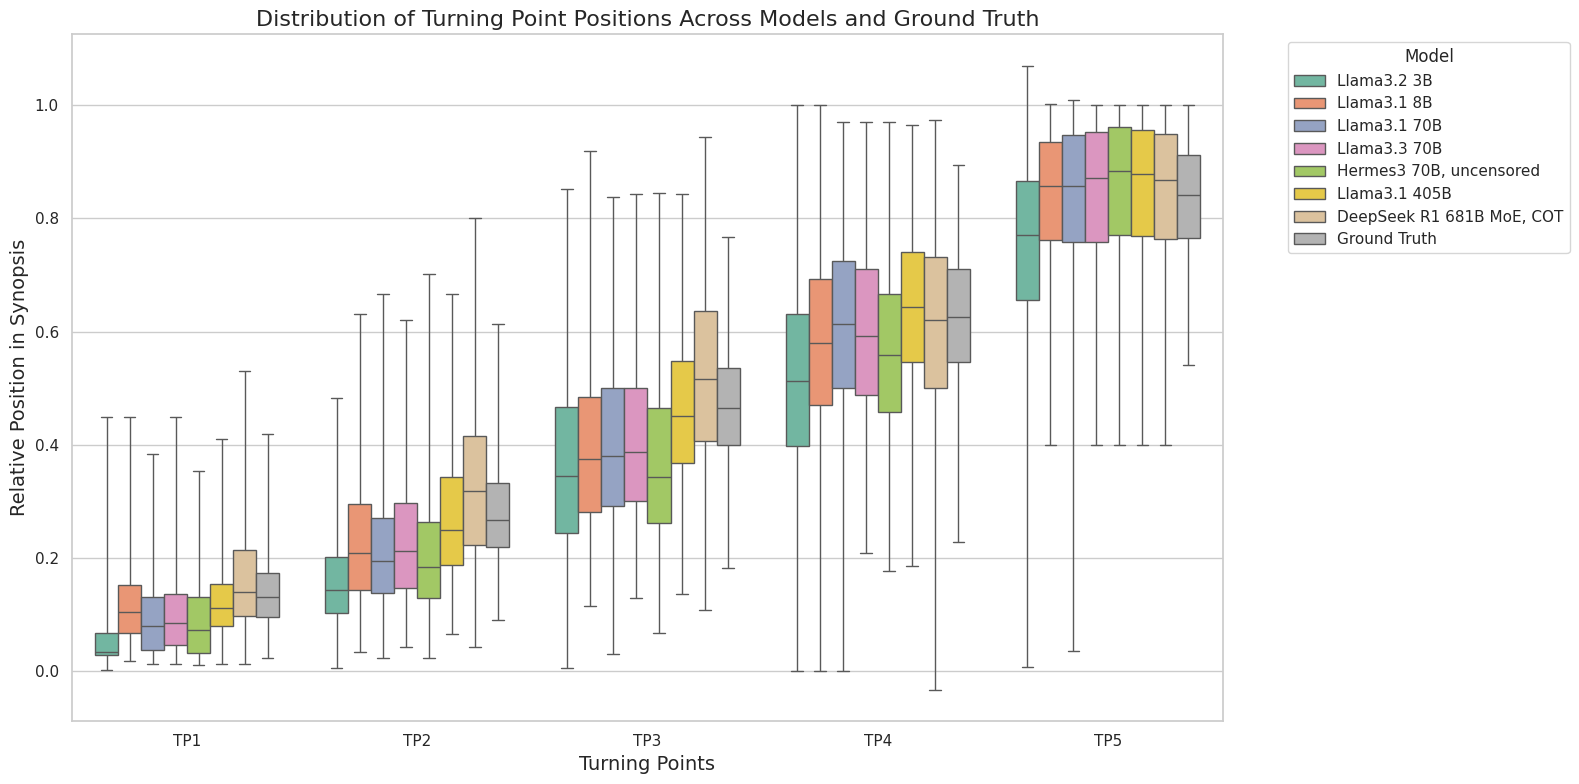

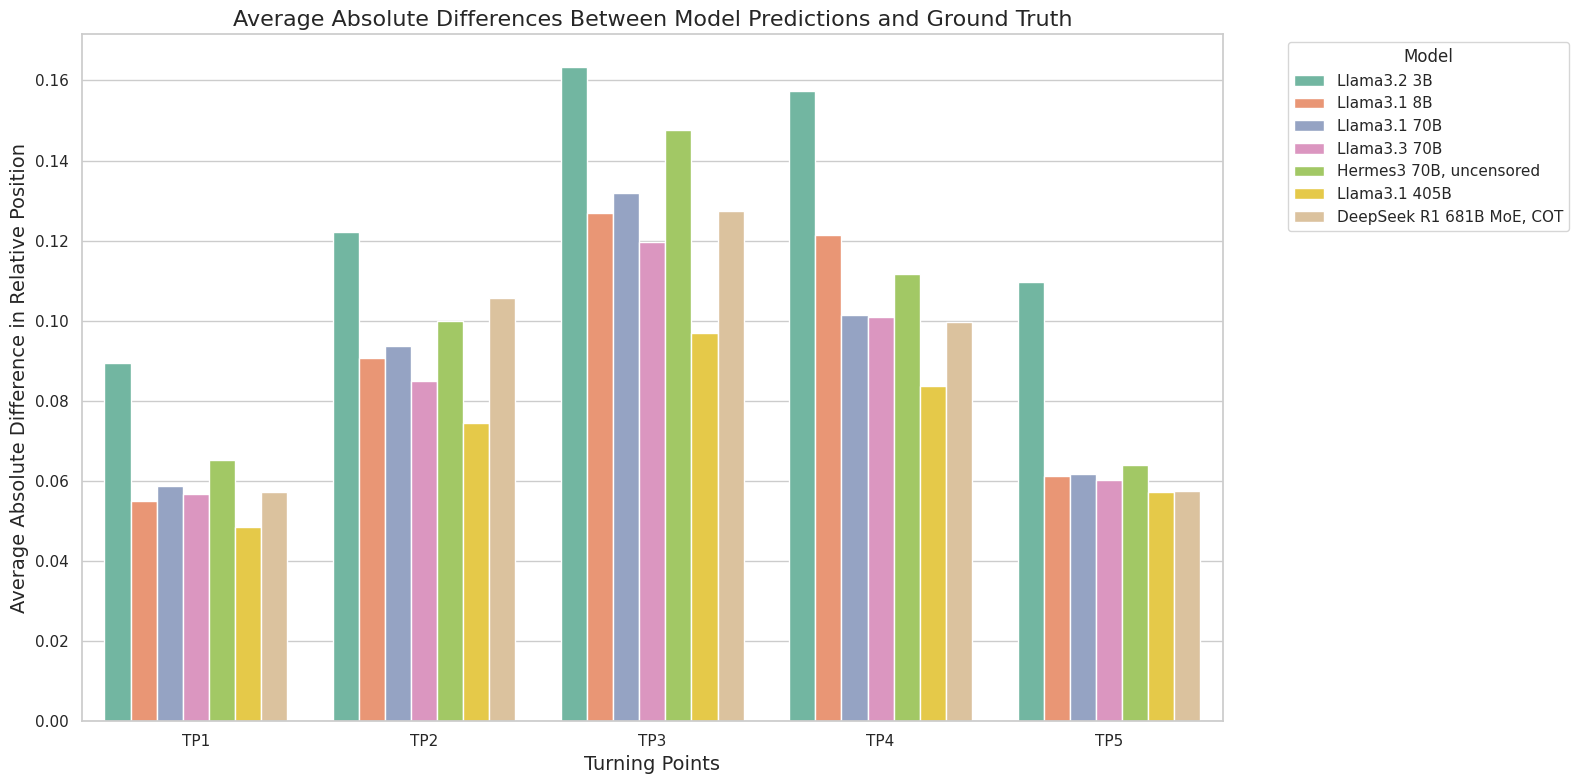

/tmp/ipykernel_14234/333968322.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


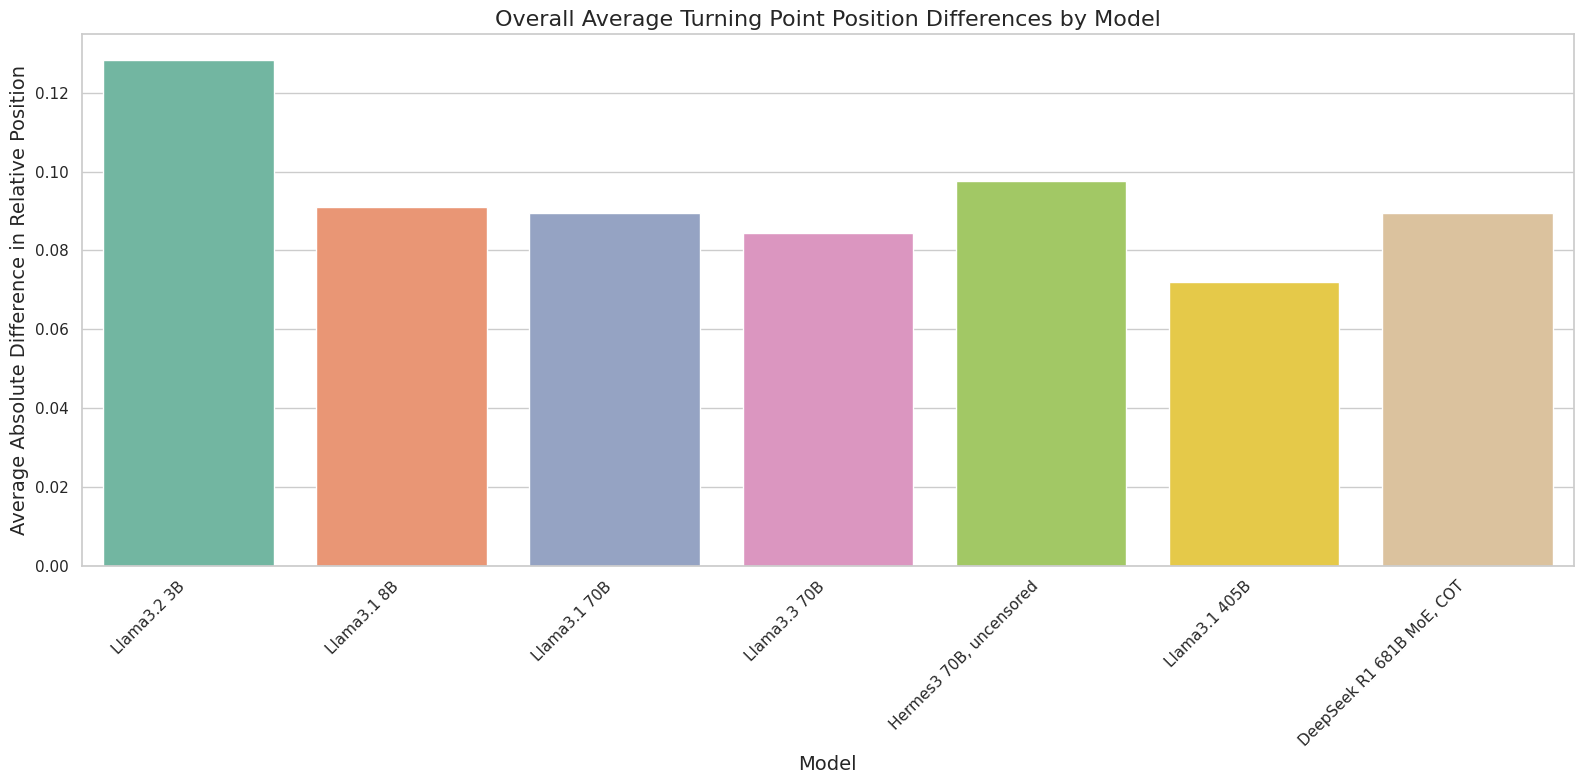

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast

# Assuming merged_df is already loaded in your environment
# If not, you can load it using pd.read_csv or other appropriate methods

# Define the model columns with friendly names
model_columns = {
    'llama3.2-3b-instruct_cleaned': 'Llama3.2 3B',
    'llama3.1-8b-instruct_cleaned': 'Llama3.1 8B', 
    'llama3.1-70b-instruct-fp8_cleaned': 'Llama3.1 70B',
    'llama3.3-70b-instruct-fp8_cleaned': 'Llama3.3 70B',
    'hermes3-70b_cleaned': 'Hermes3 70B, uncensored',
    'llama3.1-405b-instruct-fp8_cleaned': 'Llama3.1 405B',
    'deepseek-reasoner_cleaned': 'DeepSeek R1 681B MoE, COT'
}

# Initialize a list to collect data
data = []

# Function to safely parse JSON or evaluate string representation of dict
def parse_tp_dict(tp_str):
    if isinstance(tp_str, dict):
        return tp_str
    try:
        # First try json
        return json.loads(tp_str)
    except json.JSONDecodeError:
        try:
            # Fallback to ast.literal_eval
            return ast.literal_eval(tp_str)
        except:
            return {}

# Iterate through each row in the DataFrame
for idx, row in merged_df.iterrows():
    synopsis_length = row['synopsis_length']
    if synopsis_length == 0:
        continue  # Avoid division by zero

    # Process each model
    for model_col, model_name in model_columns.items():
        tp_data = parse_tp_dict(row.get(model_col, {}))
        for tp_num in range(1, 6):
            tp_key = f'tp{tp_num}'
            tp_position = tp_data.get(tp_key, None)
            if tp_position is not None:
                relative_pos = tp_position / synopsis_length
                data.append({
                    'Model': model_name,
                    'Turning Point': f'TP{tp_num}',
                    'Relative Position': relative_pos
                })

    # Process Ground Truth
    ground_truth_tp = parse_tp_dict(row.get('ground_truth', {}))
    for tp_num in range(1, 6):
        tp_key = f'tp{tp_num}'
        tp_position = ground_truth_tp.get(tp_key, None)
        if tp_position is not None:
            relative_pos = tp_position / synopsis_length
            data.append({
                'Model': 'Ground Truth',
                'Turning Point': f'TP{tp_num}',
                'Relative Position': relative_pos
            })

# Create a DataFrame from the collected data
plot_df = pd.DataFrame(data)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(16, 8))

# Create the box plot instead of violin plot
sns.boxplot(
    x='Turning Point',
    y='Relative Position',
    hue='Model',
    data=plot_df,
    palette='Set2',
    whis=[0, 100]  # Show min and max
)

# Enhance the plot with titles and labels
plt.title('Distribution of Turning Point Positions Across Models and Ground Truth', fontsize=16)
plt.xlabel('Turning Points', fontsize=14)
plt.ylabel('Relative Position in Synopsis', fontsize=14)

# Improve the legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# Save the plot as a PNG file
plt.savefig('turning_points_distribution.png', bbox_inches='tight', dpi=300)
# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

# Calculate average absolute differences between model predictions and ground truth
diff_data = []
for model_col, model_name in model_columns.items():
    # Initialize accumulators for each turning point
    tp_diffs = {f'TP{i}': {'sum': 0.0, 'count': 0} for i in range(1,6)}
    
    # Calculate differences for each row
    for idx, row in merged_df.iterrows():
        synopsis_length = row['synopsis_length']
        if synopsis_length == 0:
            continue
            
        # Get ground truth and model positions
        ground_truth_tp = parse_tp_dict(row.get('ground_truth', {}))
        model_tp = parse_tp_dict(row.get(model_col, {}))
        
        # Calculate differences for each turning point
        for tp_num in range(1, 6):
            tp_key = f'tp{tp_num}'
            
            # Get relative positions
            gt_pos = ground_truth_tp.get(tp_key, None)
            model_pos = model_tp.get(tp_key, None)
            
            if gt_pos is not None and model_pos is not None:
                # Convert to relative positions and calculate difference
                gt_rel_pos = gt_pos / synopsis_length
                model_rel_pos = model_pos / synopsis_length
                abs_diff = abs(gt_rel_pos - model_rel_pos)
                
                # Add to accumulator
                tp_diffs[f'TP{tp_num}']['sum'] += abs_diff
                tp_diffs[f'TP{tp_num}']['count'] += 1
    
    # Calculate averages and add to data
    for tp_num in range(1, 6):
        tp_key = f'TP{tp_num}'
        if tp_diffs[tp_key]['count'] > 0:
            avg_diff = tp_diffs[tp_key]['sum'] / tp_diffs[tp_key]['count']
            diff_data.append({
                'Model': model_name,
                'Turning Point': tp_key,
                'Average Absolute Difference': avg_diff
            })

# Create DataFrame for differences
diff_df = pd.DataFrame(diff_data)

# Create new figure
plt.figure(figsize=(16, 8))

# Create bar plot for average differences
sns.barplot(
    x='Turning Point',
    y='Average Absolute Difference',
    hue='Model',
    data=diff_df,
    palette='Set2'
)

# Enhance the plot
plt.title('Average Absolute Differences Between Model Predictions and Ground Truth', fontsize=16)
plt.xlabel('Turning Points', fontsize=14)
plt.ylabel('Average Absolute Difference in Relative Position', fontsize=14)

# Improve the legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot
plt.savefig('turning_points_avg_differences.png', bbox_inches='tight', dpi=300)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
# Calculate overall average difference per model
model_avg_diff = diff_df.groupby('Model')['Average Absolute Difference'].mean().reset_index()

# Create new figure 
plt.figure(figsize=(16, 8))

# Reorder the data to match model_columns order
model_order = list(model_columns.values())
model_avg_diff['Model'] = pd.Categorical(model_avg_diff['Model'], categories=model_order, ordered=True)
model_avg_diff = model_avg_diff.sort_values('Model')

# Create simplified bar plot showing overall average difference per model
sns.barplot(
    x='Model',
    y='Average Absolute Difference', 
    data=model_avg_diff,
    palette='Set2'
)

# Enhance the plot
plt.title('Overall Average Turning Point Position Differences by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Average Absolute Difference in Relative Position', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Save the plot
plt.savefig('turning_points_overall_differences.png', bbox_inches='tight', dpi=300)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


,Model,TP,p-value,Significant,Sample Sizes
0,Llama3.2 3B,TP1,0.000000,Yes,439/439
1,Llama3.2 3B,TP2,0.000000,Yes,439/439
2,Llama3.2 3B,TP3,0.000000,Yes,439/439
3,Llama3.2 3B,TP4,0.000000,Yes,435/439
4,Llama3.2 3B,TP5,0.000000,Yes,439/439
5,Llama3.1 8B,TP1,0.000000,Yes,439/439
6,Llama3.1 8B,TP2,0.000000,Yes,439/439
7,Llama3.1 8B,TP3,0.000000,Yes,438/439
8,Llama3.1 8B,TP4,0.000003,Yes,427/439
9,Llama3.1 8B,TP5,0.029935,Yes,438/439


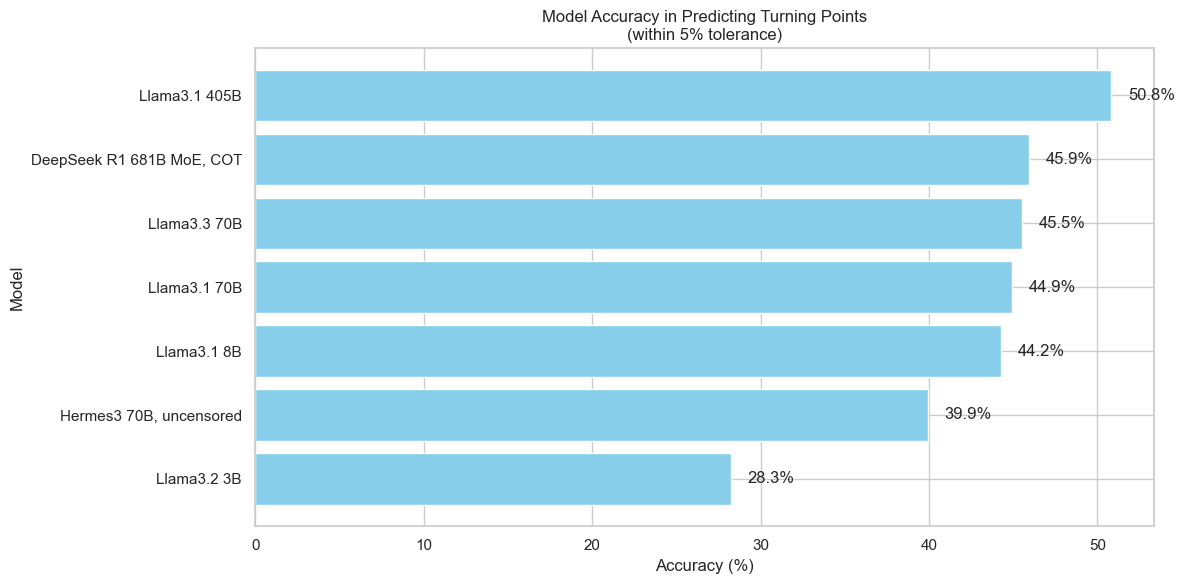

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast
from scipy import stats
from IPython.display import HTML

# Define the model columns with friendly names
model_columns = {
    'llama3.2-3b-instruct_cleaned': 'Llama3.2 3B',
    'llama3.1-8b-instruct_cleaned': 'Llama3.1 8B', 
    'llama3.1-70b-instruct-fp8_cleaned': 'Llama3.1 70B',
    'llama3.3-70b-instruct-fp8_cleaned': 'Llama3.3 70B',
    'hermes3-70b_cleaned': 'Hermes3 70B, uncensored',
    'llama3.1-405b-instruct-fp8_cleaned': 'Llama3.1 405B',
    'deepseek-reasoner_cleaned': 'DeepSeek R1 681B MoE, COT'
}

# Function to safely parse JSON or evaluate string representation of dict
def parse_tp_dict(tp_str):
    if isinstance(tp_str, dict):
        return tp_str
    try:
        return json.loads(tp_str)
    except json.JSONDecodeError:
        try:
            return ast.literal_eval(tp_str)
        except:
            return {}

# Initialize dictionaries to store positions for each model and TP
model_tp_positions = {model_name: {f'TP{i}': [] for i in range(1,6)} for model_name in model_columns.values()}
ground_truth_positions = {f'TP{i}': [] for i in range(1,6)}

# Collect the data
for idx, row in merged_df.iterrows():
    synopsis_length = row['synopsis_length']
    if synopsis_length == 0:
        continue

    # Process each model
    for model_col, model_name in model_columns.items():
        tp_data = parse_tp_dict(row.get(model_col, {}))
        for tp_num in range(1, 6):
            tp_key = f'tp{tp_num}'
            tp_position = tp_data.get(tp_key, None)
            if tp_position is not None:
                relative_pos = min(max(tp_position / synopsis_length, 0), 1)  # Floor at 0, ceiling at 1
                model_tp_positions[model_name][f'TP{tp_num}'].append(relative_pos)

    # Process Ground Truth
    ground_truth_tp = parse_tp_dict(row.get('ground_truth', {}))
    for tp_num in range(1, 6):
        tp_key = f'tp{tp_num}'
        tp_position = ground_truth_tp.get(tp_key, None)
        if tp_position is not None:
            relative_pos = min(max(tp_position / synopsis_length, 0), 1)  # Floor at 0, ceiling at 1
            ground_truth_positions[f'TP{tp_num}'].append(relative_pos)

# Create a list to store results
results = []

# Perform statistical tests and collect results
for model_name in model_columns.values():
    for tp in range(1, 6):
        tp_key = f'TP{tp}'
        model_data = model_tp_positions[model_name][tp_key]
        ground_truth_data = ground_truth_positions[tp_key]
        
        n_model = len(model_data)
        n_ground_truth = len(ground_truth_data)
        
        if n_model == 0 or n_ground_truth == 0:
            results.append({
                'Model': model_name,
                'TP': tp_key,
                'p-value': 'N/A',
                'Significant': 'N/A',
                'Sample Sizes': f'{n_model}/{n_ground_truth}'
            })
            continue
            
        # Perform Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(
            model_data, 
            ground_truth_data,
            alternative='two-sided'
        )
        
        results.append({
            'Model': model_name,
            'TP': tp_key,
            'p-value': f'{p_value:.6f}',
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Sample Sizes': f'{n_model}/{n_ground_truth}'
        })

# Create DataFrame and style it
df = pd.DataFrame(results)
styled_df = df.style.set_properties(**{
    'text-align': 'left',
    'padding': '8px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), 
                                ('text-align', 'left'),
                                ('padding', '8px'),
                                ('font-weight', 'bold')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
    {'selector': 'th', 'props': [('border', '1px solid #ddd')]}
])

# Display as HTML
display(HTML(styled_df.to_html()))

# Save as PNG using matplotlib
fig, ax = plt.subplots(figsize=(12, len(results)*0.4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, 
                colLabels=df.columns,
                cellLoc='left',
                loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

plt.title('Statistical Test Results (Mann-Whitney U test)')
plt.savefig('statistical_test_results.png', 
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.5)
plt.close()
# Calculate accuracy metrics
accuracy_data = []
for model_col, model_name in model_columns.items():
    correct_tps = 0
    total_tps = 0
    
    for idx, row in merged_df.iterrows():
        synopsis_length = row['synopsis_length']
        if synopsis_length == 0:
            continue
            
        ground_truth_tp = parse_tp_dict(row.get('ground_truth', {}))
        model_tp = parse_tp_dict(row.get(model_col, {}))
        
        # Check each turning point
        for tp_num in range(1, 6):
            tp_key = f'tp{tp_num}'
            gt_pos = ground_truth_tp.get(tp_key, None)
            model_pos = model_tp.get(tp_key, None)
            
            if gt_pos is not None and model_pos is not None:
                total_tps += 1
                # Consider positions within 5% of synopsis length as correct
                tolerance = synopsis_length * 0.05
                if abs(gt_pos - model_pos) <= tolerance:
                    correct_tps += 1
    
    if total_tps > 0:
        accuracy = (correct_tps / total_tps) * 100
        accuracy_data.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Total TPs': total_tps
        })

# Create DataFrame and sort by accuracy
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df = accuracy_df.sort_values('Accuracy', ascending=True)

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.barh(accuracy_df['Model'], accuracy_df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')
plt.title('Model Accuracy in Predicting Turning Points\n(within 5% tolerance)')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', 
             va='center')

# Adjust layout and save
plt.tight_layout()
plt.savefig('model_accuracy.png', bbox_inches='tight', dpi=300)
plt.show()

Story Arc Counts and Percentages:
                       Model             Story Arc  Count  Total  Percentage
0  DeepSeek R1 681B MoE, COT            Cinderella    213    439   48.519362
1  DeepSeek R1 681B MoE, COT  Double man in a hole     21    439    4.783599
2  DeepSeek R1 681B MoE, COT                Icarus     15    439    3.416856
3  DeepSeek R1 681B MoE, COT         Man in a hole    138    439   31.435080
4  DeepSeek R1 681B MoE, COT               Oedipus     27    439    6.150342


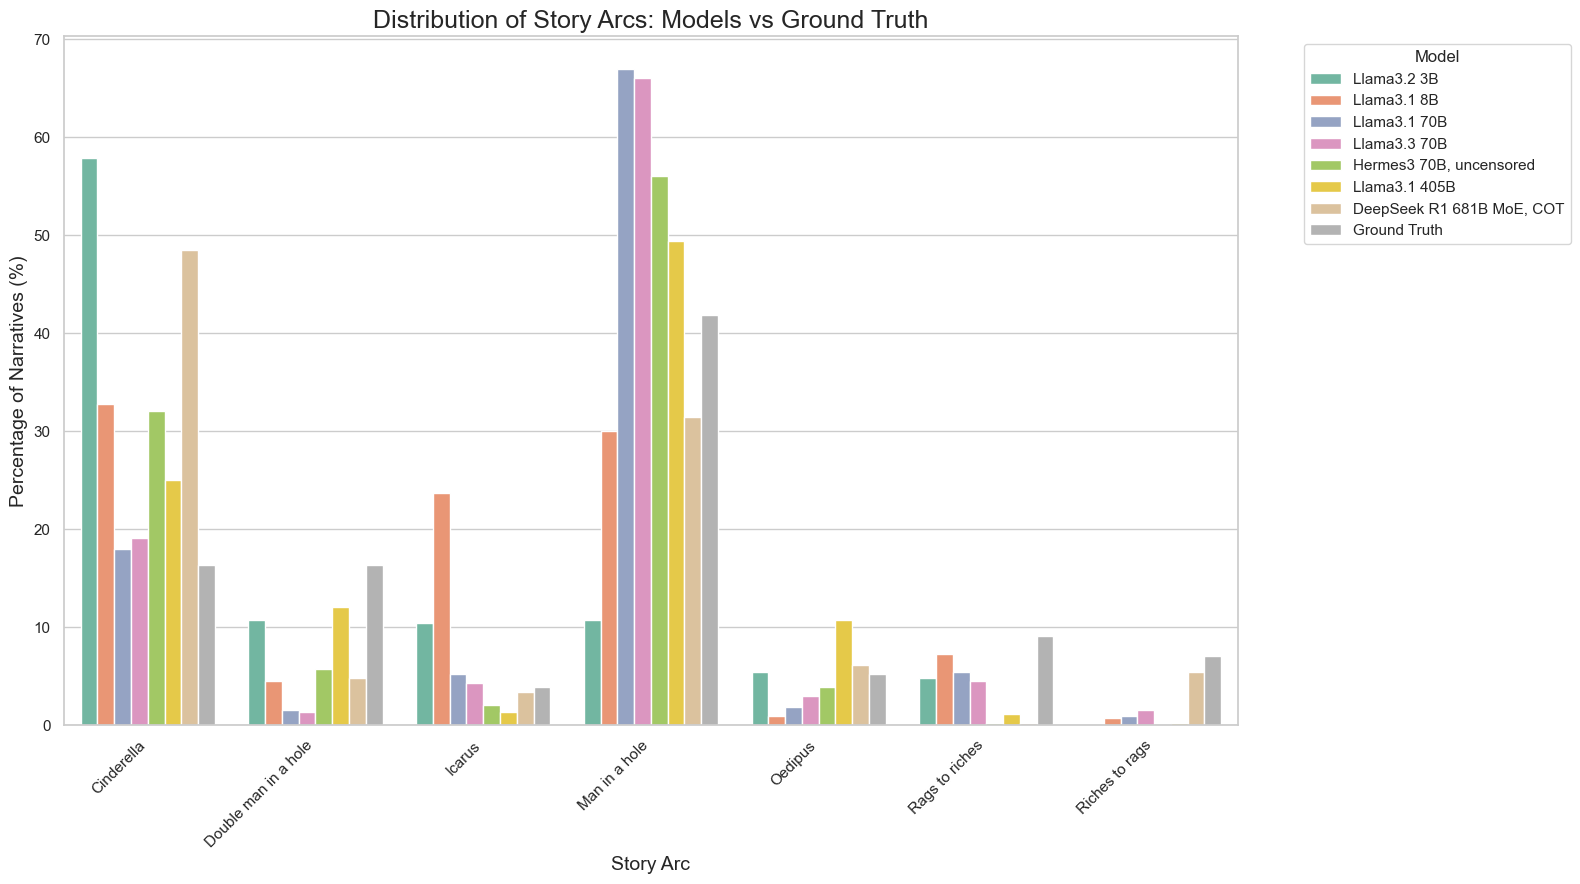

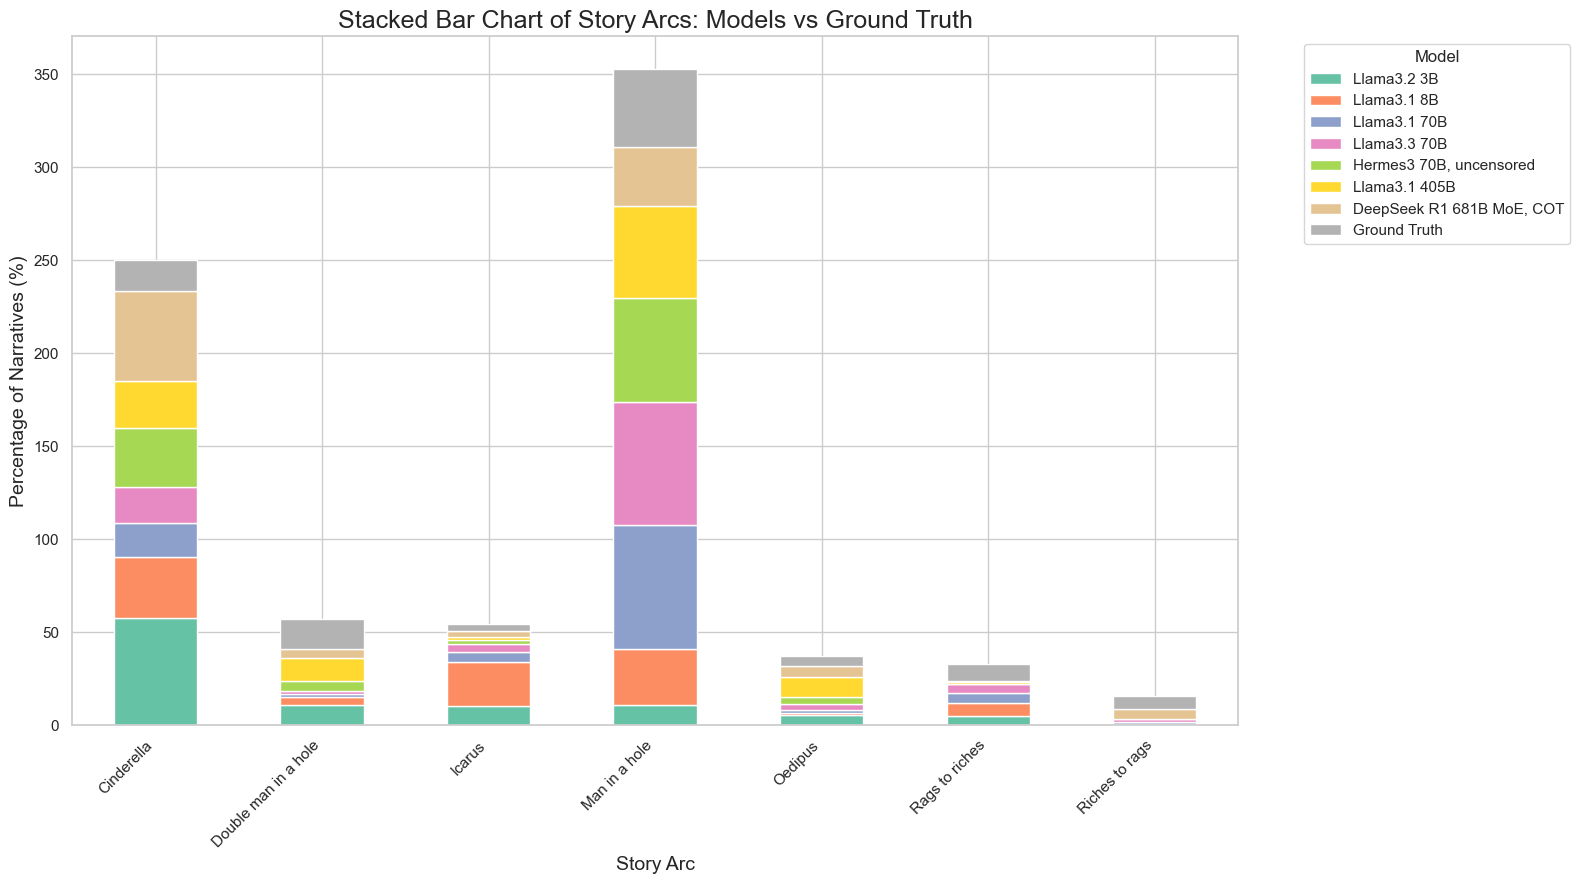

<Figure size 1600x900 with 0 Axes>

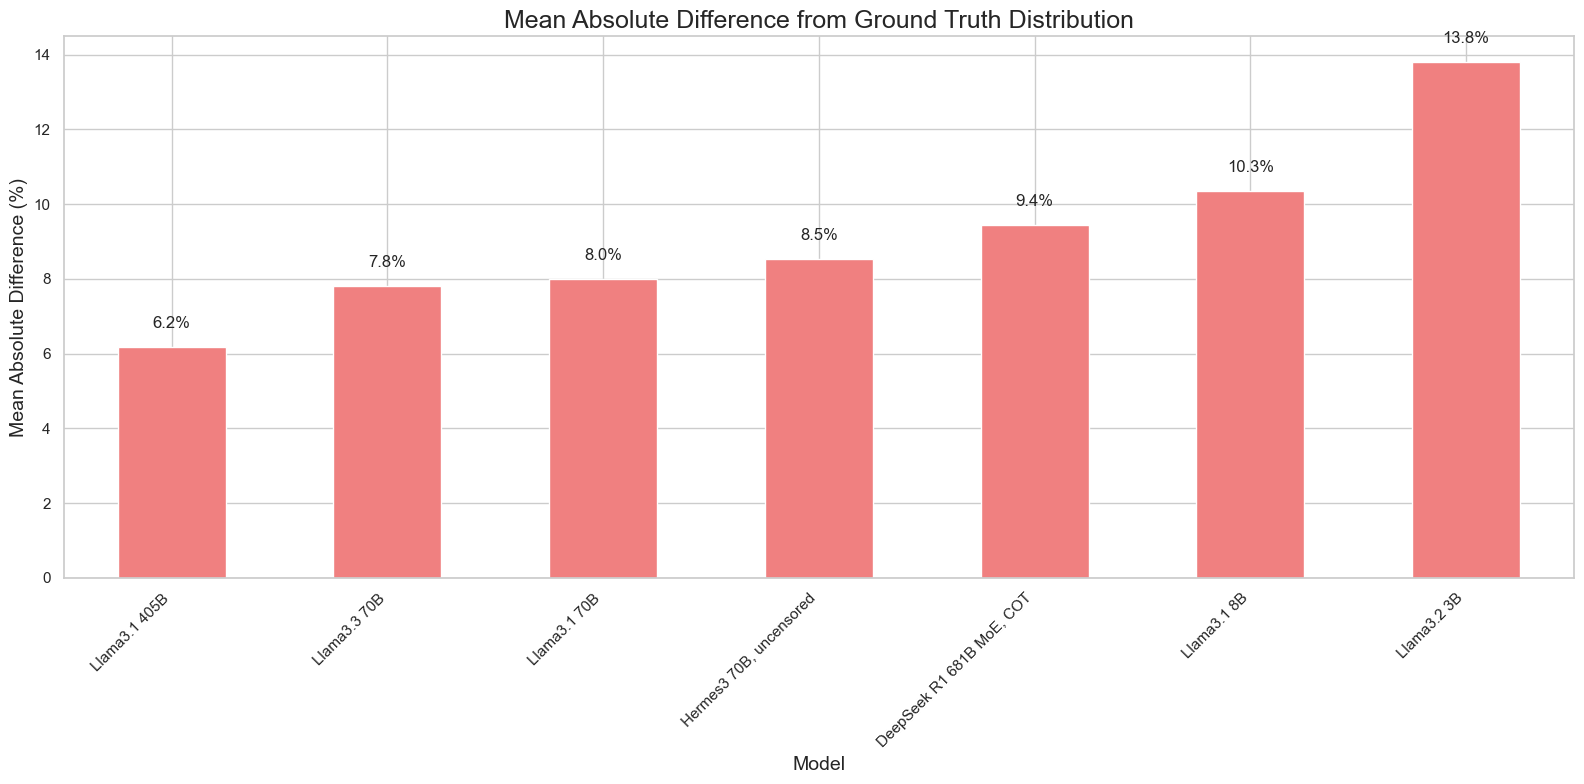

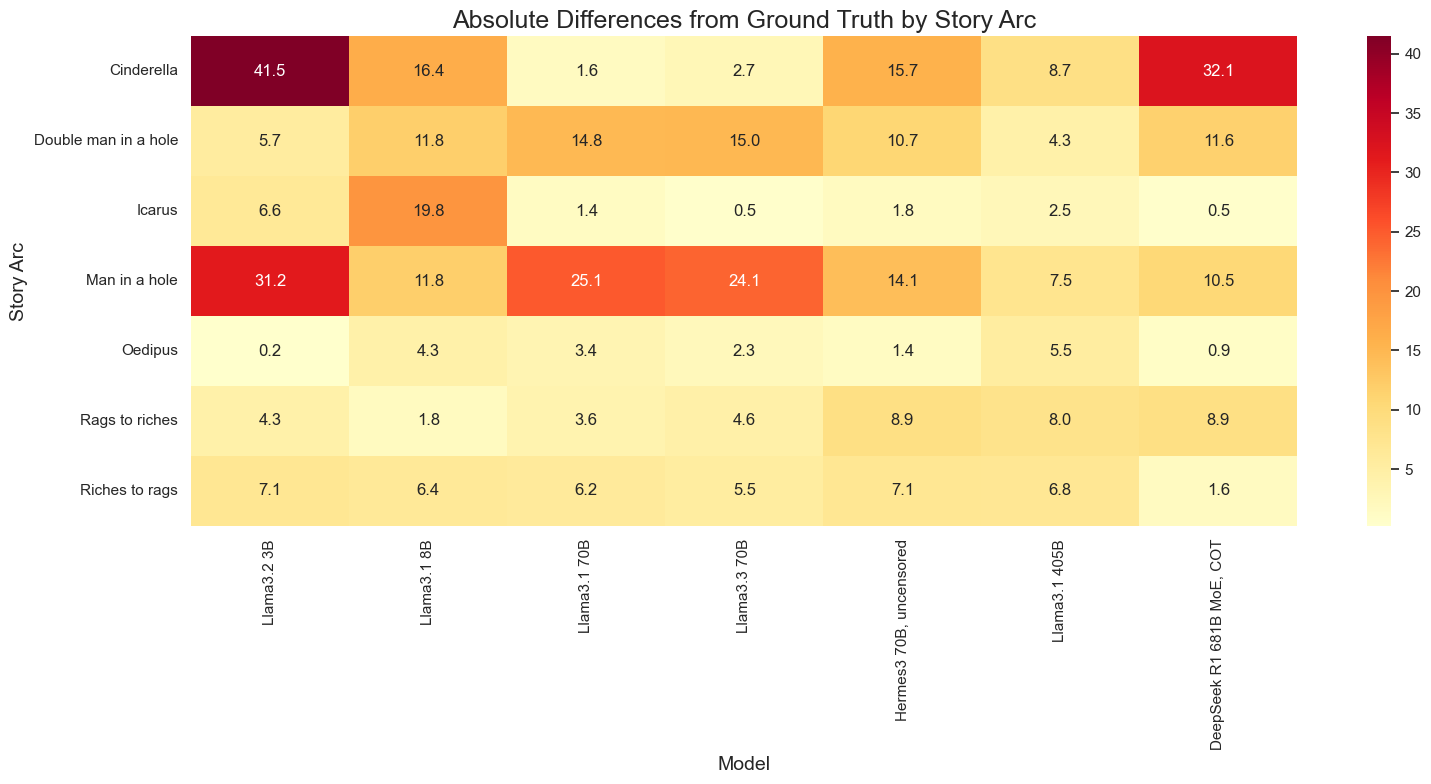

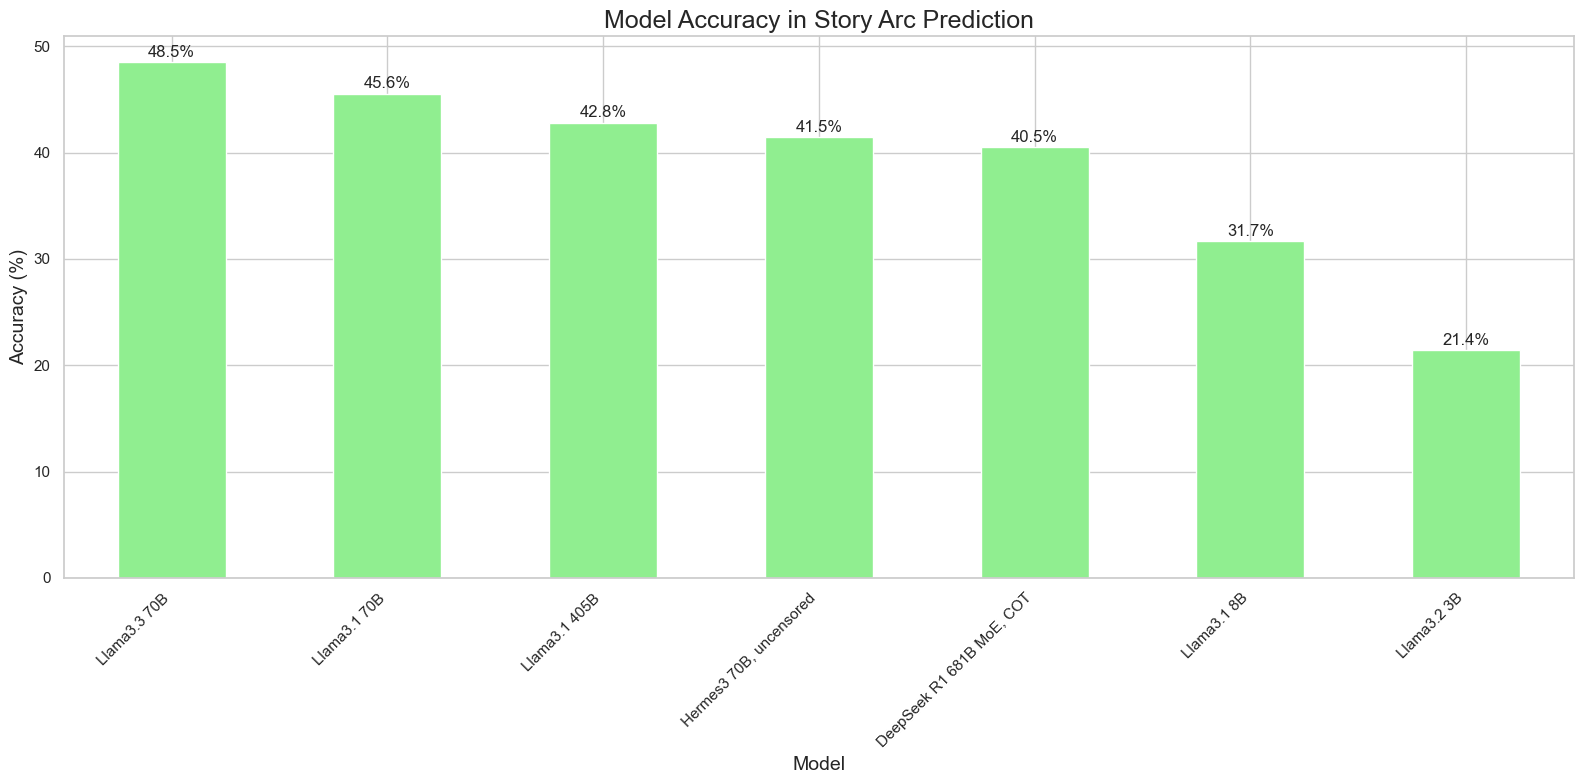


Accuracy Results:
Llama3.3 70B: 48.5%
Llama3.1 70B: 45.6%
Llama3.1 405B: 42.8%
Hermes3 70B, uncensored: 41.5%
DeepSeek R1 681B MoE, COT: 40.5%
Llama3.1 8B: 31.7%
Llama3.2 3B: 21.4%


In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast

# Define the model columns with friendly names
model_columns = {
    'llama3.2-3b-instruct_cleaned': 'Llama3.2 3B',
    'llama3.1-8b-instruct_cleaned': 'Llama3.1 8B', 
    'llama3.1-70b-instruct-fp8_cleaned': 'Llama3.1 70B',
    'llama3.3-70b-instruct-fp8_cleaned': 'Llama3.3 70B',
    'hermes3-70b_cleaned': 'Hermes3 70B, uncensored',
    'llama3.1-405b-instruct-fp8_cleaned': 'Llama3.1 405B',
    'deepseek-reasoner_cleaned': 'DeepSeek R1 681B MoE, COT'
}

# Function to safely parse JSON or evaluate string representation of dict
def parse_story_arc(tp_str):
    """
    Parses the story_arc from a JSON string or dictionary.
    
    Parameters:
    - tp_str (str or dict): The JSON string or dictionary containing story_arc.
    
    Returns:
    - story_arc (str or None): The extracted story_arc value.
    """
    if isinstance(tp_str, dict):
        return tp_str.get('story_arc', None)
    try:
        # Attempt to parse as JSON
        tp_dict = json.loads(tp_str)
        return tp_dict.get('story_arc', None)
    except (json.JSONDecodeError, TypeError):
        try:
            # Fallback to literal_eval for non-JSON strings
            tp_dict = ast.literal_eval(tp_str)
            return tp_dict.get('story_arc', None)
        except:
            return None

# Initialize a list to collect story_arc data
story_arc_data = []

# Iterate through each row in the DataFrame
for idx, row in merged_df.iterrows():
    # Process each model in order
    for model_col, model_name in model_columns.items():
        story_arc = parse_story_arc(row.get(model_col, {}))
        if story_arc is not None:
            story_arc_data.append({
                'Model': model_name,
                'Story Arc': story_arc
            })
    
    # Process Ground Truth last
    ground_truth_story_arc = parse_story_arc(row.get('ground_truth', {}))
    if ground_truth_story_arc is not None:
        story_arc_data.append({
            'Model': 'Ground Truth',
            'Story Arc': ground_truth_story_arc
        })

# Create a DataFrame from the collected data
story_arc_df = pd.DataFrame(story_arc_data)

# Drop rows with missing Story Arc
story_arc_df.dropna(subset=['Story Arc'], inplace=True)

# Standardize story_arc labels (e.g., stripping whitespace, consistent casing)
story_arc_df['Story Arc'] = story_arc_df['Story Arc'].str.strip().str.lower()

# Capitalize the first letter for better readability in plots
story_arc_df['Story Arc'] = story_arc_df['Story Arc'].str.capitalize()

# Calculate the count of each Story Arc per Model
story_arc_counts = story_arc_df.groupby(['Model', 'Story Arc']).size().reset_index(name='Count')

# Calculate the total counts per Model for percentage calculation
story_arc_counts['Total'] = story_arc_counts.groupby('Model')['Count'].transform('sum')

# Calculate the percentage
story_arc_counts['Percentage'] = (story_arc_counts['Count'] / story_arc_counts['Total']) * 100

# Create a custom order for models with Ground Truth at the end
model_order = list(model_columns.values()) + ['Ground Truth']
story_arc_counts['Model'] = pd.Categorical(story_arc_counts['Model'], categories=model_order, ordered=True)

# Display the prepared data
print("Story Arc Counts and Percentages:")
print(story_arc_counts.head())

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure for grouped bar plot
plt.figure(figsize=(16, 9))

# Create a bar plot with ordered models
sns.barplot(
    data=story_arc_counts,
    x='Story Arc',
    y='Percentage',
    hue='Model',
    hue_order=model_order,
    palette='Set2'
)

# Enhance the plot with titles and labels
plt.title('Distribution of Story Arcs: Models vs Ground Truth', fontsize=18)
plt.xlabel('Story Arc', fontsize=14)
plt.ylabel('Percentage of Narratives (%)', fontsize=14)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45, ha='right')

# Improve the legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Plotting as Stacked Bar Chart

# Pivot the data for stacked bar plot
pivot_df = story_arc_counts.pivot(index='Story Arc', columns='Model', values='Percentage').fillna(0)

# Reorder columns to match model_order
pivot_df = pivot_df[model_order]

# Plotting
pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 9),
    colormap='Set2'
)

plt.title('Stacked Bar Chart of Story Arcs: Models vs Ground Truth', fontsize=18)
plt.xlabel('Story Arc', fontsize=14)
plt.ylabel('Percentage of Narratives (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save the plots as PNG files
plt.figure(figsize=(16, 8))
sns.barplot(
    data=story_arc_counts,
    x='Story Arc',
    y='Percentage', 
    hue='Model',
    hue_order=model_order,
    palette='Set2'
)
plt.title('Distribution of Story Arcs: Models vs Ground Truth', fontsize=18)
plt.xlabel('Story Arc', fontsize=14)
plt.ylabel('Percentage of Narratives (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('story_arcs_grouped.png', dpi=300, bbox_inches='tight')
plt.close()

# Save stacked bar plot
plt.figure(figsize=(16, 9))
pivot_df.plot(
    kind='bar',
    stacked=True,
    colormap='Set2'
)
plt.title('Stacked Bar Chart of Story Arcs: Models vs Ground Truth', fontsize=18)
plt.xlabel('Story Arc', fontsize=14)
plt.ylabel('Percentage of Narratives (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('story_arcs_stacked.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate absolute differences from ground truth
ground_truth_dist = pivot_df['Ground Truth']
diff_df = pd.DataFrame()

for model in pivot_df.columns:
    if model != 'Ground Truth':
        diff_df[model] = abs(pivot_df[model] - ground_truth_dist)

# Calculate mean absolute difference for each model
mean_diffs = diff_df.mean()
mean_diffs = mean_diffs.sort_values(ascending=True)

# Create bar plot of mean absolute differences
plt.figure(figsize=(16, 8))
ax = mean_diffs.plot(kind='bar', color='lightcoral')
plt.title('Mean Absolute Difference from Ground Truth Distribution', fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Absolute Difference (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(mean_diffs):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('model_differences.png', dpi=300, bbox_inches='tight')
plt.show()

# Create heatmap of differences across story arcs
plt.figure(figsize=(16, 8))
sns.heatmap(diff_df, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Absolute Differences from Ground Truth by Story Arc', fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Story Arc', fontsize=14)
plt.tight_layout()
plt.savefig('difference_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate accuracy (exact matches with ground truth)
accuracy_data = []

for idx, row in merged_df.iterrows():
    ground_truth_arc = parse_story_arc(row.get('ground_truth', {}))
    
    if ground_truth_arc is None:
        continue
        
    # Standardize ground truth arc
    ground_truth_arc = ground_truth_arc.strip().lower()
    
    # Compare with each model
    for model_col, model_name in model_columns.items():
        model_arc = parse_story_arc(row.get(model_col, {}))
        if model_arc is not None:
            # Standardize model arc
            model_arc = model_arc.strip().lower()
            # Record match (1) or mismatch (0)
            accuracy_data.append({
                'Model': model_name,
                'Correct': 1 if model_arc == ground_truth_arc else 0
            })

# Create DataFrame and calculate accuracy percentages
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_results = accuracy_df.groupby('Model')['Correct'].mean() * 100
accuracy_results = accuracy_results.sort_values(ascending=False)

# Create bar plot for accuracy
plt.figure(figsize=(16, 8))
ax = accuracy_results.plot(kind='bar', color='lightgreen')
plt.title('Model Accuracy in Story Arc Prediction', fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(accuracy_results):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('story_arc_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed accuracy results
print("\nAccuracy Results:")
for model, accuracy in accuracy_results.items():
    print(f"{model}: {accuracy:.1f}%")